In [1]:
import pandas as pd
import pyarrow.dataset as ds
import os, psutil
import pickle
import numpy as np
import astropy.units as u
import dask.dataframe as dd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, match_coordinates_sky
from afw_utils import run_lsst_pipe_single,run_lsst_pipe_multi
from utils import get_wcs
import galsim
from astropy.visualization import ImageNormalize, AsinhStretch, ManualInterval, PercentileInterval
from astropy.table import hstack
from scipy.spatial import cKDTree
process = psutil.Process(os.getpid())

In [2]:
from main import SimCatVal
from sim import make_sim
import numpy as np
from utils import sample_position, sample_diff_position
import pickle

ind = 212
skycat_path="/hildafs/home/pladuca/main/skyCatalog.yaml"
Dp1_sample="/hildafs/home/pladuca/main/lsst-sim-package/LSST-SimCatVal/LSST-SimCatVal/outputs/ECDFS_3000_psf.pkl"
im_size=900
save_path="/hildafs/home/pladuca/main/lsst-sim-package/LSST-SimCatVal/LSST-SimCatVal/outputs_vdiff"
diff_path="/hildafs/home/pladuca/main/lsst-sim-package/LSST-SimCatVal/LSST-SimCatVal/diffsky_1_28"

with open(Dp1_sample, 'rb') as f:
    rsp_sample = pickle.load(f)

position = sample_position(1001, 223)
ra = position[ind-1][0]
dec = position[ind-1][1]
sample = rsp_sample[ind-1].copy()
sample.pop('ra')
sample.pop('dec')

diff_position = sample_diff_position(1001, 223, diff_path)
diff_ra = diff_position[ind-1][0]
diff_dec = diff_position[ind-1][1]
samp = {'i':sample['i']}

afw_dic, truths, npy_dic = make_sim(skycat_path, ra, dec, 900, 50, sample, 31.4, diff_path, diff_ra, diff_dec, n_jobs=6)
cats_f = run_lsst_pipe_multi([b for b in sample.keys()], [afw_dic[i] for i in sample.keys()], 6)

2026-02-12 22:37:33,737 - INFO - Catalog data will be read from /hildafs/home/pladuca/main/roman_rubin_cats_v1.1.2_faint/roman_rubin_cats_v1.1.2_faint/
2026-02-12 22:37:35,647 - INFO - Working on healpix pixel 10307
2026-02-12 22:37:38,200 - INFO - Working on healpix pixel 10307


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/9341 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

making_final
making psf
making afw
making save
making truth


  0%|          | 0/9341 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

making_final
making psf
making afw
making save
making truth


  0%|          | 0/9341 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

making_final
making psf
making afw
making save
making truth


  0%|          | 0/9341 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

making_final
making psf
making afw
making save
making truth


  0%|          | 0/9341 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

making_final
making psf
making afw
making save
making truth


  0%|          | 0/9341 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

making_final
making psf
making afw
making save
making truth
Starting Detections
Starting Scarlet Deblend
Deblended 506 sources
Starting Measurements (parallel with 6 jobs)
Measuring band r
Measuring band u
Measuring band g
Measuring band i
Measuring band z
Measuring band y
Starting band r
Measuring 506/506 sources (removed 0 large footprints)
Starting band g
Starting band u
Measuring 506/506 sources (removed 0 large footprints)
Measuring 506/506 sources (removed 0 large footprints)
Starting band i
Measuring 506/506 sources (removed 0 large footprints)
Starting band z
Measuring 506/506 sources (removed 0 large footprints)
Starting band y
Measuring 506/506 sources (removed 0 large footprints)
Finished band y
Finished band i
Finished band u
Finished band g
Finished band z
Finished band r
Measurements complete


In [3]:
truths_i = truths['i'][truths['i']['ob_type'] == 'diff_galaxy']
truths_star = truths['i'][truths['i']['ob_type'] == 'star']
t_mags = -2.5*np.log10(truths_i['flux']) + 31.4
cats_i = cats_f['i']
temp = cats_i
temp = temp[(temp['deblend_nChild'] == 0) &
    (temp['base_SdssShape_flag'] == False) &
    (temp['modelfit_CModel_instFlux'] >= 0) &
    (temp['modelfit_CModel_flag'] == False) &
    (temp['base_SdssCentroid_flag'] == False) ]
temp = temp[(temp['base_PsfFlux_instFlux']/temp['base_PsfFlux_instFluxErr'] >= 10)]
mags = -2.5 * np.log10(temp['modelfit_CModel_instFlux']) + 31.4
temp = temp[mags < 26.5]
truths_i = truths_i[t_mags < 26.5]

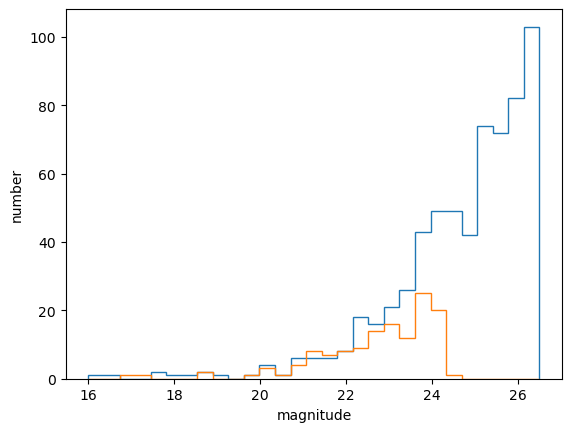

In [4]:
bins = np.linspace(16,26.5,30)
plt.hist(t_mags, bins,histtype="step",label='truth')
plt.hist(mags, bins,histtype="step",label='meas')
# plt.axvline(24.75)
plt.xlabel('magnitude')
plt.ylabel('number')
plt.show()

In [5]:
pointing = galsim.CelestialCoord(ra=ra * galsim.degrees,dec=dec * galsim.degrees)
diff_pointing = galsim.CelestialCoord(ra=diff_ra * galsim.degrees,dec=diff_dec * galsim.degrees)
wcs = get_wcs(900, pointing)

true_points = []
for i in range(len(truths_i)):
    coord = galsim.CelestialCoord(
        ra=truths_i['ra'][i] * galsim.degrees, #.value * galsim.degrees,
        dec=truths_i['dec'][i] * galsim.degrees #.value * galsim.degrees,
    )
    u_, v_ = diff_pointing.project(coord)
    dx = u_.deg * 3600
    dy = v_.deg * 3600

    world_pos = pointing.deproject(dx * galsim.arcsec, dy * galsim.arcsec,)
    image_pos = wcs.toImage(world_pos)
    true_points.append([image_pos.x,image_pos.y])
true_points = np.array(true_points)

In [6]:
pointing = galsim.CelestialCoord(ra=ra * galsim.degrees,dec=dec * galsim.degrees)
diff_pointing = galsim.CelestialCoord(ra=diff_ra * galsim.degrees,dec=diff_dec * galsim.degrees)
wcs = get_wcs(900, pointing)

true_stars = []
for i in range(len(truths_star)):
    coord = galsim.CelestialCoord(
        ra=truths_star['ra'][i] * galsim.degrees, #.value * galsim.degrees,
        dec=truths_star['dec'][i] * galsim.degrees #.value * galsim.degrees,
    )
    u_, v_ = pointing.project(coord)
    dx = u_.deg * 3600
    dy = v_.deg * 3600

    world_pos = pointing.deproject(dx * galsim.arcsec, dy * galsim.arcsec,)
    image_pos = wcs.toImage(world_pos)
    true_stars.append([image_pos.x,image_pos.y])
true_stars = np.array(true_stars)

In [7]:
truths_i['x'] = true_points[:,0]
truths_i['y'] = true_points[:,1]
truths_star['x'] = true_stars[:,0]
truths_star['y'] = true_stars[:,1]

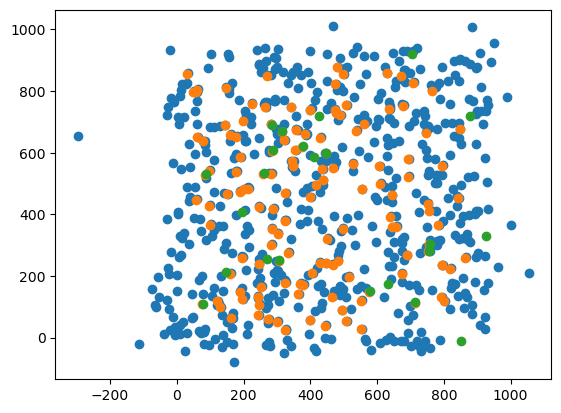

In [8]:
plt.scatter(truths_i['x'],truths_i['y'])
plt.scatter(temp['base_SdssCentroid_x'],temp['base_SdssCentroid_y'])
plt.scatter(truths_star['x'],truths_star['y'])

In [9]:
out_mask = (truths_i['x'] < 0) | (truths_i['x'] > 900) | (truths_i['y'] < 0) | (truths_i['y'] > 900)

In [10]:
print(np.sum(out_mask)/len(out_mask) * 100)

16.901408450704224


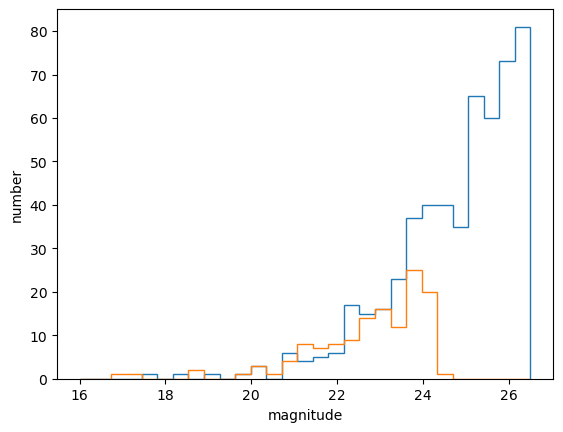

In [12]:
bins = np.linspace(16,26.5,30)
plt.hist(t_mags[t_mags<26.5][~out_mask], bins,histtype="step",label='truth')
plt.hist(mags, bins,histtype="step",label='meas')
# plt.axvline(24.75)
plt.xlabel('magnitude')
plt.ylabel('number')
plt.show()

In [ ]:
#matching move to utils?
# ob_coord = SkyCoord(ra=cats_i['coord_ra'], dec=cats_i['coord_dec'])
# true_coord = SkyCoord(ra=truths_i['x']* u.degree, dec=truths_i['dec']* u.degree)
# idx, d2d, d3d = match_coordinates_sky(ob_coord, true_coord)
# max_sep = 0.5 * u.arcsec
# sep_constraint = d2d < max_sep
# ob_matches = cats_i[sep_constraint]
# ob_fails = cats_i[~sep_constraint]
# truth_matches = truths_i[idx[sep_constraint]]
# truth_fails = truths_i[idx[~sep_constraint]]
# match = hstack([ob_matches,truth_matches])

In [13]:
ob_pix = np.column_stack([temp['base_SdssCentroid_x'],temp['base_SdssCentroid_y']])
true_pix = np.column_stack([truths_i['x'],truths_i['y']])
true_ps = np.column_stack([truths_star['x'],truths_star['y']])
tree = cKDTree(true_pix)
tree_star = cKDTree(true_ps)

dist, idx = tree.query(ob_pix, k=1)
dist_s, idx_s = tree_star.query(ob_pix, k=1)

dist = np.array(dist)
idx = np.array(idx)
dist_s = np.array(dist_s)
idx_s = np.array(idx_s)
sep_mask = dist < 5
sep_mask_s = dist_s < 5
ob_matches = temp[sep_mask | sep_mask_s]
gal_matches = temp[sep_mask]
ob_fails = temp[~(sep_mask|sep_mask_s)]
truth_matches = truths_i[idx[sep_mask]]

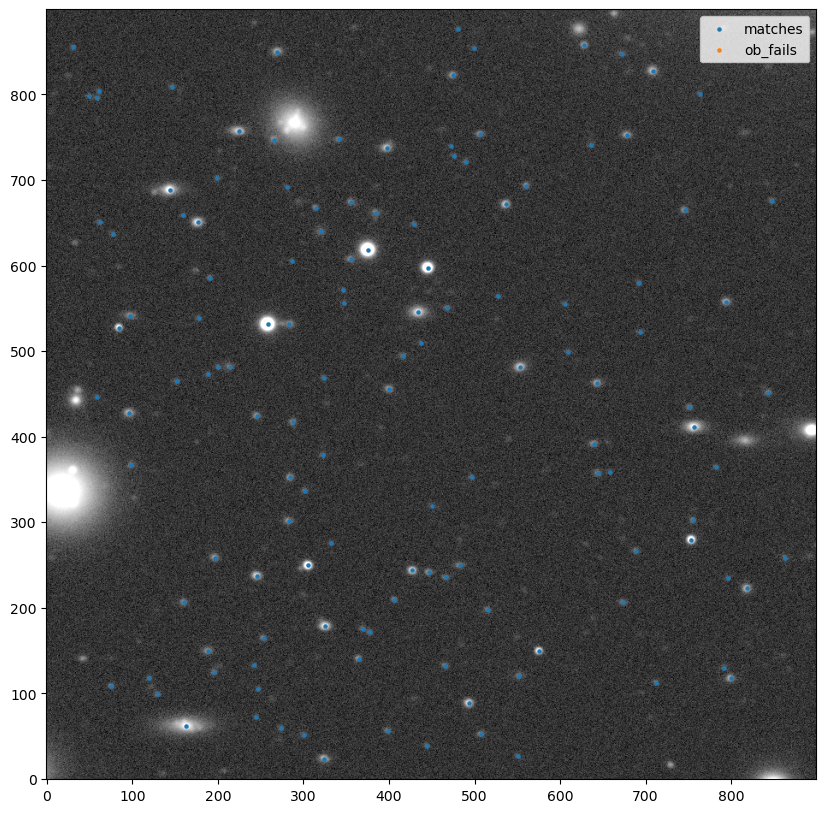

In [14]:
stretch = AsinhStretch(0.0001)
norm = ImageNormalize(
    npy_dic['i']['afw_image'].image.array,
    interval=PercentileInterval(99.5),  # clip extremes
    stretch=AsinhStretch())
fig = plt.figure(figsize=(10,10))
plt.imshow(npy_dic['i']['afw_image'].image.array, norm=norm, origin='lower', cmap='gray')
plt.scatter(ob_matches['base_SdssCentroid_x'],ob_matches['base_SdssCentroid_y'],label='matches', s=5)
plt.scatter(ob_fails['base_SdssCentroid_x'],ob_fails['base_SdssCentroid_y'],label='ob_fails', s=5)
# plt.scatter(star_matches['base_SdssCentroid_x'],star_matches['base_SdssCentroid_y'],label='ob_fails', s=1)
# plt.scatter(truth_fails['x'],truth_fails['y'],label='truth_fails')
# plt.axvline(0, color='r', linestyle='--')
# plt.axvline(900, color='r', linestyle='--')
# plt.axhline(900, color='r', linestyle='--')
# plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.show()

In [15]:
print(np.sum(sep_mask | sep_mask_s)/ len(sep_mask) * 100)

100.0


0.9344262295081968
-0.0228651149443973
0.17656342170058573


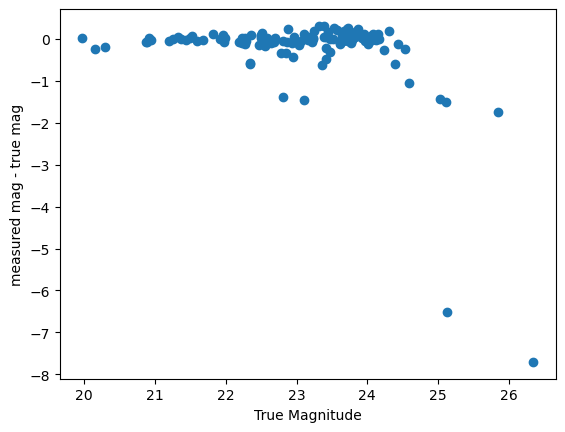

In [16]:
match_mag = -2.5 * np.log10(gal_matches['modelfit_CModel_instFlux']) + 31.4
t_match_mag = -2.5 * np.log10(truth_matches['flux']) + 31.4
d_mag = (match_mag) - (t_match_mag)

plt.scatter(t_match_mag, d_mag)
plt.xlabel('True Magnitude')
plt.ylabel('measured mag - true mag')
check = gal_matches[d_mag < -1]
print(np.sum(d_mag > -1)/len(d_mag))
print(np.mean(d_mag[d_mag > -1]))
print(np.std(d_mag[d_mag > -1]))

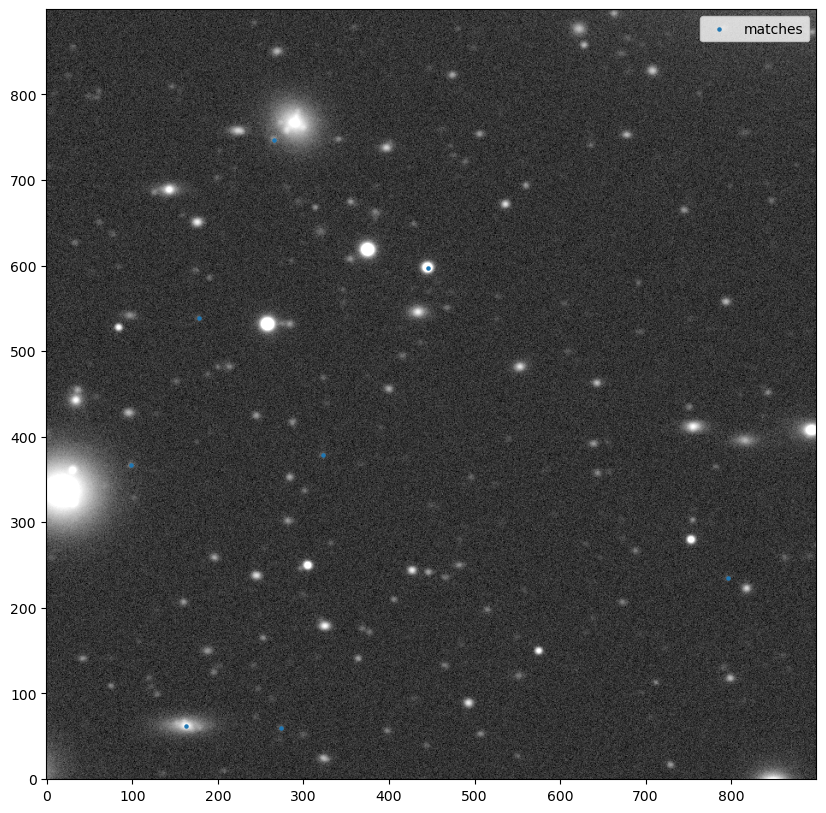

In [17]:
fig = plt.figure(figsize=(10,10))
plt.imshow(npy_dic['i']['afw_image'].image.array, norm=norm, origin='lower', cmap='gray')
plt.scatter(check['base_SdssCentroid_x'],check['base_SdssCentroid_y'],label='matches', s=5)
plt.legend()
plt.show()